# 01 — Exploração dos Dados (EDA)

Análise exploratória do dataset **B2W-Reviews01** com ~132K avaliações de produtos da Americanas.com.

**Objetivos:**
- Carregar e filtrar o dataset
- Mapear ratings para sentimento ternário (negativo/neutro/positivo)
- Visualizar distribuições e padrões
- Criar e salvar splits estratificados (70/15/15)

In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from src.config import (
    TEXT_COLUMN, RATING_COLUMN, SENTIMENT_LABELS,
    RATING_TO_SENTIMENT, FIGURES_DIR,
)
from src.data_loader import (
    carregar_dataset, filtrar_e_mapear, criar_splits, salvar_splits,
)
from src.utils import set_seed

set_seed()
sns.set_theme(style="whitegrid", palette="Set2")
%matplotlib inline

## 1. Carregamento do Dataset

In [2]:
df_raw = carregar_dataset()
print(f"Shape: {df_raw.shape}")
print(f"\nColunas: {list(df_raw.columns)}")
df_raw.head()

README.md: 0.00B [00:00, ?B/s]

b2w-reviews01.py: 0.00B [00:00, ?B/s]

default/train/0000.parquet:   0%|          | 0.00/30.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/132373 [00:00<?, ? examples/s]

Dataset carregado: 132,373 avaliações
Shape: (132373, 14)

Colunas: ['submission_date', 'reviewer_id', 'product_id', 'product_name', 'product_brand', 'site_category_lv1', 'site_category_lv2', 'review_title', 'overall_rating', 'recommend_to_a_friend', 'review_text', 'reviewer_birth_year', 'reviewer_gender', 'reviewer_state']


,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,None,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,None,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   submission_date        132373 non-null  object 
 1   reviewer_id            132373 non-null  object 
 2   product_id             132373 non-null  object 
 3   product_name           132289 non-null  object 
 4   product_brand          40982 non-null   object 
 5   site_category_lv1      132367 non-null  object 
 6   site_category_lv2      128360 non-null  object 
 7   review_title           132071 non-null  object 
 8   overall_rating         132373 non-null  int32  
 9   recommend_to_a_friend  132355 non-null  object 
 10  review_text            129098 non-null  object 
 11  reviewer_birth_year    126389 non-null  float64
 12  reviewer_gender        128237 non-null  object 
 13  reviewer_state         128382 non-null  object 
dtypes: float64(1), int32(1), object(12)


In [4]:
# Valores nulos
nulos = df_raw.isnull().sum()
print("Valores nulos por coluna:")
print(nulos[nulos > 0])

Valores nulos por coluna:
product_name                84
product_brand            91391
site_category_lv1            6
site_category_lv2         4013
review_title               302
recommend_to_a_friend       18
review_text               3275
reviewer_birth_year       5984
reviewer_gender           4136
reviewer_state            3991
dtype: int64


## 2. Distribuição de Ratings (Original)

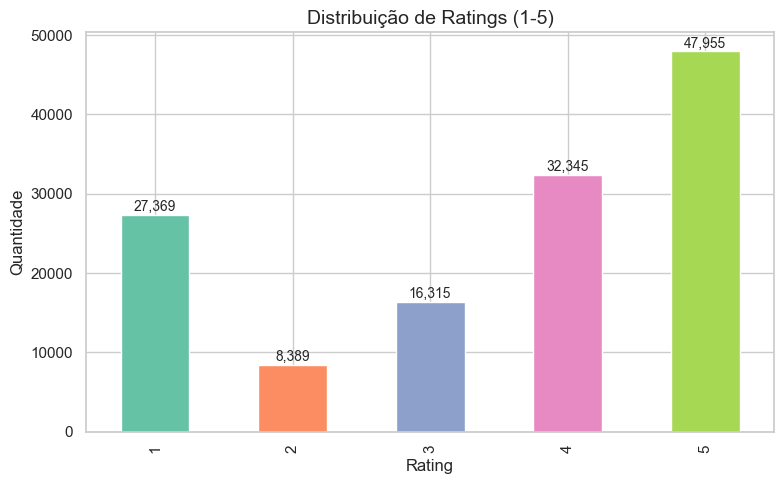

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
rating_counts = df_raw[RATING_COLUMN].value_counts().sort_index()
rating_counts.plot(kind="bar", ax=ax, color=sns.color_palette("Set2", 5))
ax.set_title("Distribuição de Ratings (1-5)", fontsize=14)
ax.set_xlabel("Rating")
ax.set_ylabel("Quantidade")
for i, v in enumerate(rating_counts):
    ax.text(i, v + 500, f"{v:,}", ha="center", fontsize=10)
plt.tight_layout()
fig.savefig(FIGURES_DIR / "distribuicao_ratings.png", dpi=150)
plt.show()

## 3. Filtro e Mapeamento de Sentimento

In [6]:
df = filtrar_e_mapear(df_raw)

Filtrados 3,275 registros nulos/vazios → 129,098 restantes
Distribuição de sentimento:
sentimento
positivo    79316
negativo    33772
neutro      16010


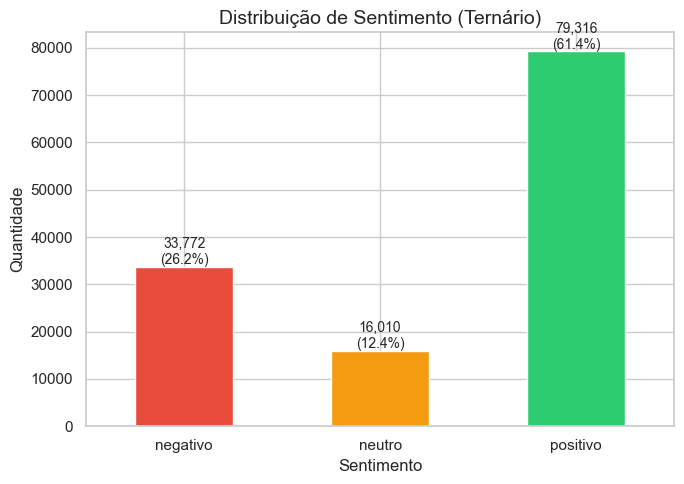

In [7]:
fig, ax = plt.subplots(figsize=(7, 5))
sent_counts = df["sentimento"].value_counts().reindex(SENTIMENT_LABELS)
colors = ["#e74c3c", "#f39c12", "#2ecc71"]
sent_counts.plot(kind="bar", ax=ax, color=colors)
ax.set_title("Distribuição de Sentimento (Ternário)", fontsize=14)
ax.set_xlabel("Sentimento")
ax.set_ylabel("Quantidade")
ax.set_xticklabels(SENTIMENT_LABELS, rotation=0)
for i, v in enumerate(sent_counts):
    pct = v / len(df) * 100
    ax.text(i, v + 500, f"{v:,}\n({pct:.1f}%)", ha="center", fontsize=10)
plt.tight_layout()
fig.savefig(FIGURES_DIR / "distribuicao_sentimento.png", dpi=150)
plt.show()

## 4. Comprimento dos Textos

In [8]:
df["num_chars"] = df[TEXT_COLUMN].str.len()
df["num_words"] = df[TEXT_COLUMN].str.split().str.len()

print("Estatísticas de comprimento (caracteres):")
print(df["num_chars"].describe())
print(f"\nEstatísticas de comprimento (palavras):")
print(df["num_words"].describe())

Estatísticas de comprimento (caracteres):
count    129098.000000
mean        136.746154
std         126.364490
min          50.000000
25%          68.000000
50%          95.000000
75%         155.000000
max        4548.000000
Name: num_chars, dtype: float64

Estatísticas de comprimento (palavras):
count    129098.000000
mean         23.022665
std          22.152798
min           1.000000
25%          11.000000
50%          16.000000
75%          27.000000
max         795.000000
Name: num_words, dtype: float64


/var/folders/0x/f3ysthvx15g71kxkdntwphqr0000gq/T/ipykernel_16964/700375027.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="sentimento", y="num_words", order=SENTIMENT_LABELS,


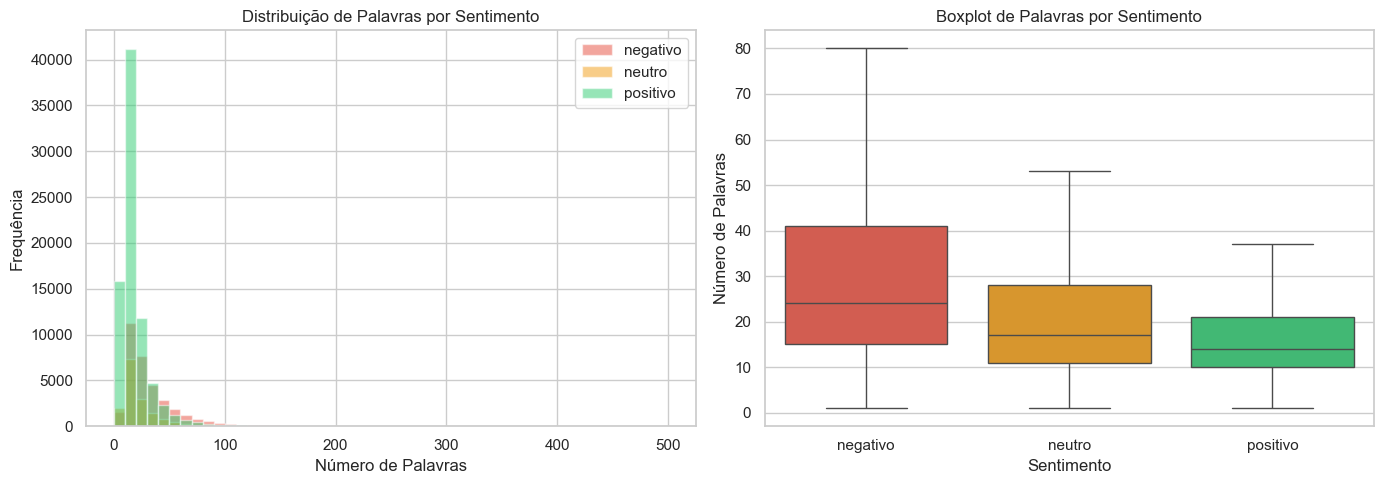

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de palavras por sentimento
for sent, color in zip(SENTIMENT_LABELS, colors):
    subset = df[df["sentimento"] == sent]["num_words"]
    axes[0].hist(subset, bins=50, alpha=0.5, label=sent, color=color, range=(0, 500))
axes[0].set_title("Distribuição de Palavras por Sentimento")
axes[0].set_xlabel("Número de Palavras")
axes[0].set_ylabel("Frequência")
axes[0].legend()

# Boxplot
sns.boxplot(data=df, x="sentimento", y="num_words", order=SENTIMENT_LABELS,
            palette=colors, ax=axes[1], showfliers=False)
axes[1].set_title("Boxplot de Palavras por Sentimento")
axes[1].set_xlabel("Sentimento")
axes[1].set_ylabel("Número de Palavras")

plt.tight_layout()
fig.savefig(FIGURES_DIR / "comprimento_textos.png", dpi=150)
plt.show()

## 5. Categorias de Produtos

In [10]:
if "product_category" in df.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    top_cats = df["product_category"].value_counts().head(15)
    top_cats.plot(kind="barh", ax=ax, color=sns.color_palette("Set2", 15))
    ax.set_title("Top 15 Categorias de Produtos", fontsize=14)
    ax.set_xlabel("Quantidade")
    ax.invert_yaxis()
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "top_categorias.png", dpi=150)
    plt.show()
else:
    print("Coluna 'product_category' não encontrada.")

Coluna 'product_category' não encontrada.


## 6. WordClouds por Sentimento

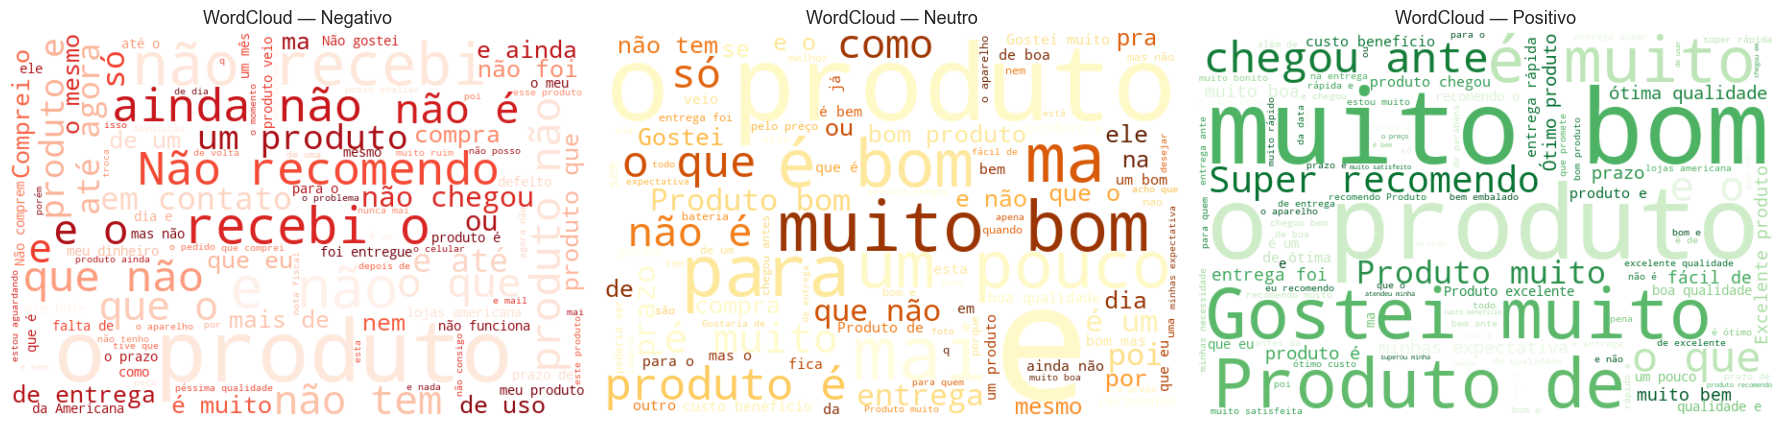

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, sent, color in zip(axes, SENTIMENT_LABELS, ["Reds", "YlOrBr", "Greens"]):
    text = " ".join(df[df["sentimento"] == sent][TEXT_COLUMN].astype(str).tolist())
    wc = WordCloud(
        width=600, height=400,
        background_color="white",
        colormap=color,
        max_words=100,
        random_state=42,
    ).generate(text)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"WordCloud — {sent.capitalize()}", fontsize=13)
    ax.axis("off")

plt.tight_layout()
fig.savefig(FIGURES_DIR / "wordclouds_sentimento.png", dpi=150)
plt.show()

## 7. Criação e Salvamento dos Splits

In [12]:
df_train, df_val, df_test = criar_splits(df)

# Verificar estratificação
print("\nDistribuição por split:")
for nome, split in [("Treino", df_train), ("Validação", df_val), ("Teste", df_test)]:
    dist = split["sentimento"].value_counts(normalize=True).reindex(SENTIMENT_LABELS)
    print(f"  {nome}: " + " | ".join(f"{s}: {v:.1%}" for s, v in dist.items()))

Splits: treino=90,368 | val=19,365 | teste=19,365

Distribuição por split:
  Treino: negativo: 26.2% | neutro: 12.4% | positivo: 61.4%
  Validação: negativo: 26.2% | neutro: 12.4% | positivo: 61.4%
  Teste: negativo: 26.2% | neutro: 12.4% | positivo: 61.4%


In [13]:
salvar_splits(df_train, df_val, df_test)
print("\nSplits salvos com sucesso!")

Splits salvos em /Users/devsquad/PLN-sentiments/data/processed

Splits salvos com sucesso!


## Resumo

- Dataset carregado e filtrado com sucesso
- Mapeamento ternário aplicado (1-2→negativo, 3→neutro, 4-5→positivo)
- Dataset desbalanceado: maioria positivo, minoria neutro
- Splits estratificados criados e salvos em `data/processed/`
- Próximo passo: **02_preprocessamento.ipynb**